# 第3章 k近邻法

> * k-nearest neighbor, k-NN。一种基本的分类与回归方法。本节只讨论分类问题中的K-NN法。
> * 输入：实例的特征向量。
> * 输出：实例的类别，可以是多类别。
> * 首先有一个训练集；对于新的实例，根据其k个最近邻的训练实例的类别，通过多数表决等方式进行预测。
> * 不具备显式学习过程。
> * 本质：运用training data，将特征空间进行划分，并作为其分类的model；送进一个新的实例，会看该实例位于特征空间的哪一个划分中，来标记其类别。
> * 三个基本要素：k值的选择，距离度量，分类决策规则。

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 边际可视化
from matplotlib.colors import ListedColormap

# classification <= 5
def plot_decision_regions(X, y, classifier=None, scaler = None, resolution=0.02, need_samples=1):
    # setup marker generator and color map
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # In this way, we can just draw a scatter pic
    if classifier:
        # plot the decision surface
        x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
        x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
        xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                              np.arange(x2_min,x2_max,resolution))
        temp = np.array([xx1.ravel(),xx2.ravel()]).T
        if scaler:
            temp = scaler.transform(temp)
        Z = classifier.predict(temp)
        Z = Z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())
    
    if need_samples:
        # plot class samples
        for idx,cl in enumerate(np.unique(y)):
            plt.scatter(x=X[y==cl,0],
                        y=X[y==cl,1],
                        alpha=0.8,
                        c=colors[idx],
                        marker=markers[idx],
                        label=cl,
                        edgecolor='black')

## 3.1 k近邻算法

__定义__：给定一个训练数据集，对于新的输入实例，在训练数据集中找到与该实例最近邻(涉及“距离度量”)的k个实例(涉及“k值选择”)，这k个实例的多数属于某个类就把该输入实例分为这个类(涉及“分类决策规则”)。

__算法: k-nn__

* 输入：
    1. 训练数据集，其中$\mathbf{x_i}\in \mathbf{R}^n$，$y_i \in \{c_1,c_2,\cdots,c_K\}$，$i=1,2,\cdots,N$
$$T=\{(\mathbf{x_1},y_1),(\mathbf{x_2},y_2),\cdots,(\mathbf{x_N},y_N)\}$$
    2. 实例$\mathbf{x}$
* 输出：实例$\mathbf{x}$所属的类别$y$
* 过程：
    1. 根据给定的距离度量，在训练集$T$中找到与$\mathbf{x}$最邻近的$k$个点，涵盖这$k$个点的邻域记做$N_k(\mathbf{x})$；
    2. 在$N_k(\mathbf{x})$中根据分类决策规则(如多数决)，决定$\mathbf{x}$的类别$y$：
$$y = \underset{c_j}{argmax}\sum_{x_i \in N_k(\mathbf{x})} I(y_i=c_j),\quad i=1,2,\cdots,N;\quad j=1,2,\cdots,K$$

## 3.2 k近邻模型

### 一. 模型

对于k-nn，当“三要素”以及training data给定后，特征空间中的每一个点，其所属的类(预测)被唯一确定，也就是特征空间被唯一地划分了。

__最近邻算法__：$k=1$时，新输入的实例的类别由与它最近的训练集中的实例确定。

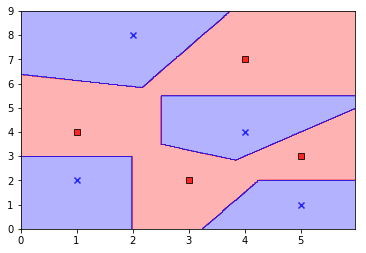

In [28]:
# 最邻法
from sklearn.neighbors import KNeighborsClassifier
X = np.array([[1,4],[3,2],[5,1],[2,8],[4,7],[4,4],[5,3],[1,2]])
y = np.array([0,0,1,1,0,1,0,1])
knn = KNeighborsClassifier(n_neighbors=1, p=2)
knn.fit(X,y)
plot_decision_regions(X,y,classifier=knn)

### 二. 距离度量

距离，实质上是__相似性__的一种度量。不同的距离度量方法，可能得到不同的k近邻区域。

Minkowski距离：

$$L_p(\mathbf{x_i},\mathbf{x_j}) = \Big(\sum^n_{l=1}|x_i^{(l)}-x_j^{(l)}|^p\Big)^{\frac{1}{p}}$$

* $p=2$时，是__欧氏距离(欧几里得距离)__;
* $p=1$时，是__曼哈顿距离__;
* $p=\infty$时，是__切比雪夫距离__。

在scikit-learn中，knn也有参数$p$，即距离度量的选择。

### 三. k值选择

* $k$值变大——模型变复杂——容易过拟合；
* $k$值变小——模型变简单——容易欠拟合；
* 使用交叉验证选择合适的$k$值。

### 四. 分类决策规则

往往是__多数表决(majority voting)__：由输入实例的$k$个近邻的训练实例中的多数类决定输入实例的类别。

## 3.3 k近邻法的实现: kd树

实现k近邻法，必须要做到__快速__找到k近邻区域，即__快速__进行k近邻搜索——当特征的维度很大，训练数据容量很大的时候，一个一个算距离需要耗费大量时间(称为“线性扫描”)，是不可行的。因此，必要设计其他高效的算法，能够快速找到对于某个输入实例的$k$个近邻点。

核心思路：使用特殊的数据结构存储训练数据，以致于能够更快地找到对于某个任意实例的$k$个近邻点。下面介绍一种数据结构——__kd树__。

### 一. 构造kd树

kd树是一种对$k$维空间中的实例进行存储以便对其进行快速检索的树形数据结构：

* 是二叉树；
* 表示对$k$维空间的一个划分；
* 构造的过程，相当于不断地用垂直于坐标轴的超平面将$k$维空间切分，切成一系列的$k$维超矩形区域。

__平衡kd树__：按照如下方式切分得到的kd树是平衡kd树

* 依次选择坐标轴对空间进行切分；
* 选择训练实例点在选定坐标轴上的中位数为切分点。

__结点(Node)__：kd树的一个结点对应一个超矩形区域，并存储着该超矩形区域的切分点。

__算法：构造平衡kd树__——递归

if 区域中无任何实例(termination criteria) met:

    return None

else:

* __生成新结点__
* __确定切分维度__：对深度为$j$的结点，选择$x^{(l)}$为切分的维度(坐标轴)，其中$l=j(mod\ k)+1$；
* __确定切分实例__：以该结点的区域中所有实例的$x^{(l)}$坐标的中位数为切分点，将该结点对应的超矩形区域切分为两个子区域——将该切分实例保存至该结点中；
* __切分__：切分通过切分点并与坐标轴$x^{(l)}$垂直的超平面实现；
* __生成左右子区域(结点)__：由该结点的切分生成深度为$j+1$的左右子区域(结点)——左子区域(结点)对应坐标$x^{(l)}$小于等于切分点的子区域，右子区域(结点)对应坐标$x^{(l)}$大于切分点的子区域；
* __递归__：重复。

举例：给定一个二维空间的数据集，构造一个平衡kd树

$$T = \{(2,3)^T, (5,4)^T, (9,6)^T, (4,7)^T, (8,1)^T, (7,2)^T\}$$

解答：
* 首先，该区域中有实例，则生成一个新结点，切分维度为$0mod2+1=1$，将该区域中的实例按照第1维度排序得$T = \{(2,3)^T, (4,7)^T, (5,4)^T, (7,2)^T, (8,1)^T, (9,6)^T\}$，该维度的中位数所对应的实例为$(7,2)^T$，因此将$(7,2)^T$保存至该结点中，并以$x^{(1)}=7$将该区域划分为左右两个子区域；

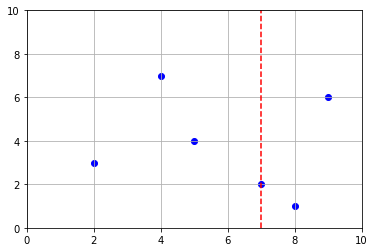

In [58]:
plt.xlim([0,10])
plt.ylim([0,10])
plt.grid()
plt.scatter([2,5,9,4,8,7],[3,4,6,7,1,2],color='b')
plt.plot([7,7],[0,10],'--',color='r');

* (第2层左子区域)：有实例，则生成一个新结点，切分维度为$1mod2+1=2$，将该区域中的实例按照第2维度排序得$T = \{(2,3)^T, (5,4)^T, (4,7)^T\}$，该维度的中位数所对应的实例为$(5,4)^T$，因此将$(5,4)^T$保存至该结点中，并以$x^{(2)}=4$将该区域划分为左右两个子区域；

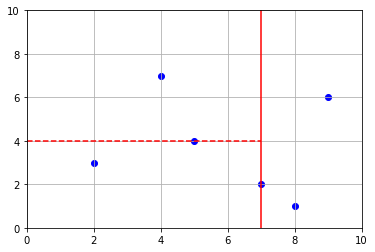

In [59]:
plt.xlim([0,10])
plt.ylim([0,10])
plt.grid()
plt.scatter([2,5,9,4,8,7],[3,4,6,7,1,2],color='b')
plt.plot([7,7],[0,10],color='r');
plt.plot([0,7],[4,4],'--',color='r');

* (第2层右子区域)：有实例，则生成一个新结点，切分维度为$1mod2+1=2$，将该区域中的实例按照第2维度排序得$T = \{(8,1)^T, (9,6)^T\}$，该维度的中位数所对应的实例为$(9,6)^T$，因此将$(9,6)^T$保存至该结点中，并以$x^{(2)}=6$将该区域划分为左右两个子区域；

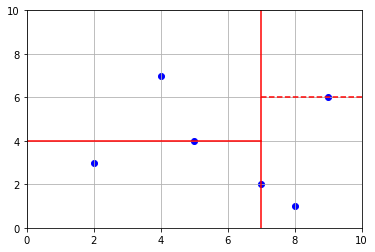

In [60]:
plt.xlim([0,10])
plt.ylim([0,10])
plt.grid()
plt.scatter([2,5,9,4,8,7],[3,4,6,7,1,2],color='b')
plt.plot([7,7],[0,10],color='r');
plt.plot([0,7],[4,4],color='r');
plt.plot([7,10],[6,6],'--',color='r');

* (第3层左左子区域)：有实例，则生成一个新结点，切分维度为$2mod2+1=1$，将该区域中的实例按照第1维度排序得$T = \{(2,3)^T\}$，该维度的中位数所对应的实例为$(2,3)^T$，因此将$(2,3)^T$保存至该结点中，并以$x^{(1)}=2$将该区域划分为左右两个子区域；

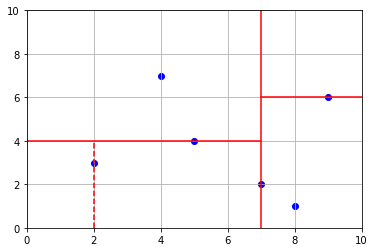

In [61]:
plt.xlim([0,10])
plt.ylim([0,10])
plt.grid()
plt.scatter([2,5,9,4,8,7],[3,4,6,7,1,2],color='b')
plt.plot([7,7],[0,10],color='r');
plt.plot([0,7],[4,4],color='r');
plt.plot([7,10],[6,6],color='r');
plt.plot([2,2],[0,4],'--',color='r');

* (第3层左右子区域)：有实例，则生成一个新结点，切分维度为$2mod2+1=1$，将该区域中的实例按照第1维度排序得$T = \{(4,7)^T\}$，该维度的中位数所对应的实例为$(4,7)^T$，因此将$(4,7)^T$保存至该结点中，并以$x^{(1)}=4$将该区域划分为左右两个子区域；

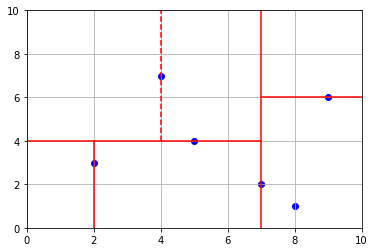

In [62]:
plt.xlim([0,10])
plt.ylim([0,10])
plt.grid()
plt.scatter([2,5,9,4,8,7],[3,4,6,7,1,2],color='b')
plt.plot([7,7],[0,10],color='r');
plt.plot([0,7],[4,4],color='r');
plt.plot([7,10],[6,6],color='r');
plt.plot([2,2],[0,4],color='r');
plt.plot([4,4],[4,10],'--',color='r');

* (第3层右左子区域)：有实例，则生成一个新结点，切分维度为$2mod2+1=1$，将该区域中的实例按照第1维度排序得$T = \{(8,1)^T\}$，该维度的中位数所对应的实例为$(8,1)^T$，因此将$(8,1)^T$保存至该结点中，并以$x^{(1)}=8$将该区域划分为左右两个子区域；

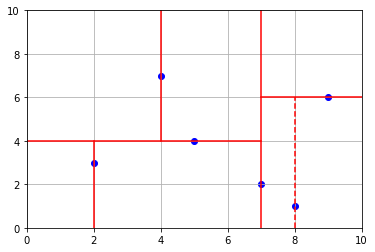

In [65]:
plt.xlim([0,10])
plt.ylim([0,10])
plt.grid()
plt.scatter([2,5,9,4,8,7],[3,4,6,7,1,2],color='b')
plt.plot([7,7],[0,10],color='r');
plt.plot([0,7],[4,4],color='r');
plt.plot([7,10],[6,6],color='r');
plt.plot([2,2],[0,4],color='r');
plt.plot([4,4],[4,10],color='r');
plt.plot([8,8],[0,6],'--',color='r');

* (第3层右右子区域)：没有实例。
* (第4层所有区域)：没有实例，结束，得到的kd树如下：

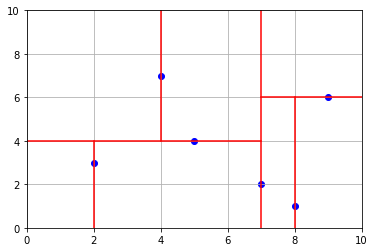

In [67]:
plt.xlim([0,10])
plt.ylim([0,10])
plt.grid()
plt.scatter([2,5,9,4,8,7],[3,4,6,7,1,2],color='b')
plt.plot([7,7],[0,10],color='r');
plt.plot([0,7],[4,4],color='r');
plt.plot([7,10],[6,6],color='r');
plt.plot([2,2],[0,4],color='r');
plt.plot([4,4],[4,10],color='r');
plt.plot([8,8],[0,6],color='r');

### 二. 搜索kd树

#### 1. 最邻搜索

算法：

1. __在kd tree中找出包含目标点$\mathbf{x}$的leaf node__——从current root node出发，向下访问kd tree，若目标点$\mathbf{x}$当前维度的坐标小于切分点的坐标，则移动到左子结点，否则移动到右子结点(若只有一个子结点，则移动到该子结点)——直到子结点为叶结点为止；
2. __保存该path上的所有node__；
3. __以“后进先出”的方式回退检索上述node__:
    * if “当前最近点”为空: 
        * 则该node为“当前最近点”；
    * else:
        * if 该结点比“当前最近点”更近:
            * 替换“当前最近点”；
    * if 该结点有2个子结点:
        * if 目标点$\mathbf{x}$到该结点切分超平面的距离小于“当前最近点”:
            * 以另一子结点为current root node，递归执行该最邻搜索。

最近点为:(-5.2817175226345565, -3.224172040135075), 距离为:5.572262101870562
构建kd树用时: 0.000067秒
检索用时: 0.000974秒


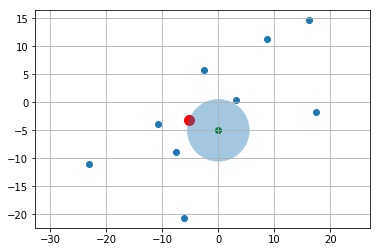

In [74]:
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

class Node:
    """二叉树结点
    Parameters
    --------------
    left: Node
        左子结点
    right: Node
        右子结点
    point: tuple
        该结点存储的切分点
    dim: int
        该结点的切分维度，是索引，因此真正的维度应该是dim+1
    """
    def __init__(self, left, right, point, dim):
        self.left  = left
        self.right = right
        self.point = point
        self.dim   = dim

    def get_child_num(self):
        """返回该结点的子结点数目
        Return
        --------------
        : int, 0 or 1 or 2      
            子结点数目
        """
        return int(self.right != None) + int(self.left != None)

class KdTree:
    """kd树
    Parameters
    --------------
    training_data: list of tuple
        训练样本数据点
    
    Attributes
    --------------
    dim_: int
        样本维度
    kdtree_: Node
        kd树(根节点表示)
    nearest_: list of Node
        存储当前最邻点
    min_dist_: float
        与当前最邻点的距离
    """
    def __init__(self, training_data):
        self.training_data = training_data
        self.dim_ = len(training_data[0])
        self.kdtree_ = None
        self.nearest_  = [-999]                              # 储存"当前最近"点(Node)
        self.min_dist_ = float('inf')                        # 储存"当前最近"点与目标的距离

    def create_tree(self):
        """构造kd树"""
        kdtree = self.create_tree_real(self.training_data)
        self.kdtree_ = kdtree

    def create_tree_real(self, point_list, depth=0):
        """实际构造kd树函数
        Parameters
        --------------
        point_list: list by tuples
            训练数据点(或其一部分)
        depth: int
            结点深度，默认是0，即root位置

        Returns
        --------------
        Node: Node
            kd树(以根节点表示)
        """
        if not point_list:  # 递归的base criteria
            return None
        dim_index = depth%self.dim_
        point_list = sorted(point_list, key=lambda x:x[dim_index])
        median_index = len(point_list)//2
        return Node(
                point  = point_list[median_index],
                left  = self.create_tree_real(point_list[:median_index], depth+1),
                right = self.create_tree_real(point_list[median_index+1:], depth+1),
                dim = dim_index
        )

    def compute_distance(self, p1, p2):
        """计算两点间的欧氏距离
        Parameters
        --------------
        p1: tuple
            点1
        p2: tuple
            点2

        Returns
        --------------
        distance: float
            两点的欧氏距离
        """
        p1 = np.array(p1)
        p2 = np.array(p2)
        distance = np.sqrt(np.sum((p1-p2)*(p1-p2)))
        return distance

    def find_nearest_one(self, query_point):
        """寻找最近点"""
        if not self.kdtree_:
            print("Attention: 请先构建kd树!")
            return None
        self.find_nearest_one_real(self.kdtree_, query_point)
        print("最近点为:%s, 距离为:%s" % (str(self.nearest_[0].point), str(self.min_dist_)))
        return self.nearest_[0].point, self.min_dist_

    def find_nearest_one_real(self, root, query_point):
        """实际检索函数
        Parameters
        --------------
        query_point: tuple
            目标数据点

        Returns
        --------------
        nearest_[0]: Node
            最近点
        min_dist_: float
            最近点对应的最近距离
        """
        node_list = []                                                              # 储存待检查的结点
        cursor_node = root                                                          # 不需要deepcopy
        while cursor_node:                                                          # 二叉检索，获得子结点，并将路径结点保存
            node_list.append(cursor_node)
            if cursor_node.get_child_num() == 1:                                    # 如果下面只剩一个结点，无论是左是右，都走下去
                cursor_node = cursor_node.left if cursor_node.left else cursor_node.right
            else:
                dim = cursor_node.dim
                if query_point[dim] < cursor_node.point[dim]:
                    cursor_node = cursor_node.left
                else:
                    cursor_node = cursor_node.right
        while node_list:                                                            # 回退检索
            back_point = node_list.pop()
            btq_dist = self.compute_distance(back_point.point, query_point)
            if btq_dist < self.min_dist_:
                self.nearest_[0] = back_point
                self.min_dist_ = btq_dist
            dim = back_point.dim
            if back_point.get_child_num() == 2:                                     # 确定有左右两个子结点，有一个或没有都不用进行以下步骤
                if abs(query_point[dim] - back_point.point[dim]) < self.min_dist_:
                    if query_point[dim] < back_point.point[dim]:                    # 以当前最近点与目标点连线为半径的圆与同父兄弟的矩形空间相交，因此需要检查同父兄弟的矩形空间
                        cursor_node = back_point.right
                        self.find_nearest_one_real(cursor_node,query_point)
                    else:
                        cursor_node = back_point.left
                        self.find_nearest_one_real(cursor_node,query_point)

def draw_pic(X,query_point,min_dist_):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.scatter([i[0] for i in X], [i[1] for i in X])
    plt.scatter(nearest_point[0],nearest_point[1],s=100,c='r')
    plt.scatter(query_point[0],query_point[1],c='g')
    plt.grid()
    cir = Circle(xy=query_point, radius=min_dist_, alpha=0.4)
    ax.add_patch(cir)
    plt.axis('scaled')
    plt.axis('equal')
    plt.show()

if __name__ == '__main__':
    # 数据生成
    n = 10
    np.random.seed(1)
    temp = np.random.randn(2*n)*10
    X = temp[:n]
    Y = temp[n:]
    input_ = list(zip(X,Y))
    query_point = (0,-5)

    # 构建kd树并搜寻
    time1 = time.time()
    kt = KdTree(input_)
    kt.create_tree()
    time2 = time.time()
    nearest_point,min_dist_ = kt.find_nearest_one(query_point)
    time3 = time.time()
    print("构建kd树用时: %f秒" % (time2-time1))
    print("检索用时: %f秒" % (time3-time2))
    draw_pic(input_,query_point,min_dist_)

#### 2. k邻搜索

算法：

1. __在kd tree中找出包含目标点$\mathbf{x}$的leaf node__——从current root node出发，向下访问kd tree，若目标点$\mathbf{x}$当前维度的坐标小于切分点的坐标，则移动到左子结点，否则移动到右子结点(若只有一个子结点，则移动到该子结点)——直到子结点为叶结点为止；
2. __保存该path上的所有node__；
3. __以“后进先出”的方式回退检索上述node__:
    * if “当前k近邻点”数目小于$k$: 
        * 则将该node添加至“当前k近邻点”；
    * else:
        * if 该结点比“当前k近邻点”中最远的点更近:
            * 替换“当前k近邻点”中最远的点；
    * if 该结点有2个子结点:
        * if 目标点$\mathbf{x}$到该结点切分超平面的距离小于“当前k近邻点”中最远的点:
            * 以另一子结点为current root node，递归执行该k邻搜索。

k=5最近点为:[(3.1903909605709857, 0.4221374671559283), (-7.612069008951028, -8.778584179213718), (-5.2817175226345565, -3.224172040135075), (-10.729686221561705, -3.8405435466841564), (-2.493703754774101, 5.828152137158222)], 距离为:[6.291118278496214, 8.498311184961215, 5.572262101870562, 10.792150187998073, 11.111590215717039]
构建kd树用时: 0.000085秒
检索用时: 0.000923秒


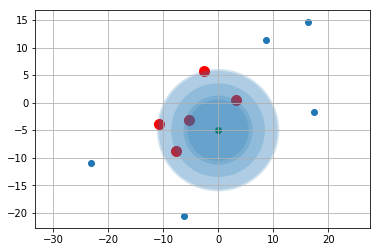

In [76]:
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

class Node:
    """二叉树结点
    Parameters
    --------------
    left: Node
        左子结点
    right: Node
        右子结点
    point: tuple
        该结点存储的切分点
    dim: int
        该结点的切分维度，是索引，因此真正的维度应该是dim+1
    """
    def __init__(self, left, right, point, dim):
        self.left  = left
        self.right = right
        self.point = point
        self.dim   = dim

    def get_child_num(self):
        """返回该结点的子结点数目
        Return
        --------------
        : int, 0 or 1 or 2      
            子结点数目
        """
        return int(self.right != None) + int(self.left != None)

class KdTree:
    """kd树
    Parameters
    --------------
    training_data: list of tuple
        训练样本数据点
    
    Attributes
    --------------
    dim_: int
        样本维度
    kdtree_: Node
        kd树(根节点表示)
    nearest_: list of Node
        存储当前最邻点
    min_dist_: float
        与当前最邻点的距离
    """
    def __init__(self, training_data):
        self.training_data = training_data
        self.dim_ = len(training_data[0])
        self.kdtree_ = None
        self.nearest_  = []
        self.min_dist_ = []

    def create_tree(self):
        """构造kd树"""
        kdtree = self.create_tree_real(self.training_data)
        self.kdtree_ = kdtree

    def create_tree_real(self, point_list, depth=0):
        """实际构造kd树函数
        Parameters
        --------------
        point_list: list by tuples
            训练数据点(或其一部分)
        depth: int
            结点深度，默认是0，即root位置

        Returns
        --------------
        Node: Node
            kd树(以根节点表示)
        """
        if not point_list:  # 递归的base criteria
            return None
        dim_index = depth%self.dim_
        point_list = sorted(point_list, key=lambda x:x[dim_index])
        median_index = len(point_list)//2
        return Node(
                point  = point_list[median_index],
                left  = self.create_tree_real(point_list[:median_index], depth+1),
                right = self.create_tree_real(point_list[median_index+1:], depth+1),
                dim = dim_index
        )

    def compute_distance(self, p1, p2):
        """计算两点间的欧氏距离
        Parameters
        --------------
        p1: tuple
            点1
        p2: tuple
            点2

        Returns
        --------------
        distance: float
            两点的欧氏距离
        """
        p1 = np.array(p1)
        p2 = np.array(p2)
        distance = np.sqrt(np.sum((p1-p2)*(p1-p2)))
        return distance

    def find_nearest_k(self, query_point, k=1):
        """寻找最近的k个点"""
        if not self.kdtree_:
            print("Attention: 请先构建kd树!")
            return None
        self.find_nearest_k_real(self.kdtree_, query_point, k)
        nearest_points = [i.point for i in self.nearest_]
        min_distances  = self.min_dist_
        print("k=%s最近点为:%s, 距离为:%s" % (str(k), str(nearest_points), str(min_distances)))
        return nearest_points,min_distances

    def find_nearest_k_real(self, root, query_point, k=1):
        """实际检索函数
        Parameters
        --------------
        root: Node
            搜索的起始位置
        query_point: tuple
            目标数据点
        k: int
            k邻
        """
        node_list = []                                                              # 储存待检查的结点
        cursor_node = root                                                          # 不需要deepcopy
        while cursor_node:                                                          # 二叉检索，获得子结点，并将路径结点保存
            node_list.append(cursor_node)
            if cursor_node.get_child_num() == 1:                                    # 如果下面只剩一个结点，无论是左是右，都走下去
                cursor_node = cursor_node.left if cursor_node.left else cursor_node.right
            else:
                dim = cursor_node.dim
                if query_point[dim] < cursor_node.point[dim]:
                    cursor_node = cursor_node.left
                else:
                    cursor_node = cursor_node.right
        while node_list:                                                            # 回退检索
            back_point = node_list.pop()
            btq_dist = self.compute_distance(back_point.point, query_point)
            if len(self.nearest_) < k:                                              # 如果存储当前最近点的列表不满k个，则直接加入
                self.nearest_.append(back_point)
                self.min_dist_.append(btq_dist)
            elif btq_dist < max(self.min_dist_):
                replace_index = self.min_dist_.index(max(self.min_dist_))           # 如果存储当前最近点的列表满k个，则与其中距离最大的点进行比较，看是否可以替换
                self.nearest_[replace_index] = back_point
                self.min_dist_[replace_index] = btq_dist
            dim = back_point.dim
            if back_point.get_child_num() == 2:                                     # 确定有左右两个子结点，有一个或没有都不用进行以下步骤
                if abs(query_point[dim] - back_point.point[dim]) < max(self.min_dist_):
                    if query_point[dim] < back_point.point[dim]:                    # 以当前最近点集合中最远点与目标点连线为半径的圆与同父兄弟的矩形空间相交，因此需要检查同父兄弟的矩形空间
                        cursor_node = back_point.right
                        self.find_nearest_k_real(cursor_node,query_point,k)
                    else:
                        cursor_node = back_point.left
                        self.find_nearest_k_real(cursor_node,query_point,k)

def draw_pic(X,query_point,nearest_points,min_distances):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for j in min_distances:
        cir = Circle(xy=query_point, radius=j, alpha=0.2)
        ax.add_patch(cir)
        plt.axis('scaled')
        plt.axis('equal')
    plt.scatter([i[0] for i in X], [i[1] for i in X])
    plt.scatter([i[0] for i in nearest_points],[i[1] for i in nearest_points],s=100,c='r')
    plt.scatter(query_point[0],query_point[1],c='g')
    plt.grid()
    plt.show()

if __name__ == '__main__':
    # 数据生成
    n = 10
    np.random.seed(1)
    temp = np.random.randn(2*n)*10
    X = temp[:n]
    Y = temp[n:]
    input_ = list(zip(X,Y))
    query_point = (0,-5)
    # 构建kd树并搜寻
    time1 = time.time()
    kt = KdTree(input_)
    kt.create_tree()
    time2 = time.time()
    nearest_points,min_distances = kt.find_nearest_k(query_point,k=5)
    time3 = time.time()
    print("构建kd树用时: %f秒" % (time2-time1))
    print("检索用时: %f秒" % (time3-time2))
    draw_pic(input_,query_point,nearest_points,min_distances)